In [679]:
import yfinance as yf
data = yf.download('Reliance.NS', start="2021-10-21", end="2022-02-16", progress = False)
data.reset_index(inplace=True)

data = data.reset_index()
print(data.columns)
print(data["Date"].dtype)

MultiIndex([( 'index',            ''),
            (  'Date',            ''),
            ( 'Close', 'RELIANCE.NS'),
            (  'High', 'RELIANCE.NS'),
            (   'Low', 'RELIANCE.NS'),
            (  'Open', 'RELIANCE.NS'),
            ('Volume', 'RELIANCE.NS')],
           names=['Price', 'Ticker'])
datetime64[ns]


In [680]:
sent_df = pd.read_csv('/Users/gursheelsingh/Downloads/reliance_news_sentiment.csv')
sent_df["date"] = pd.to_datetime(sent_df["published_at"]).dt.date

# Map sentiment to numeric
sentiment_map = {
    "positive": 1,
    "neutral": 0,
    "negative": -1
}

sent_df["sentiment_num"] = sent_df["sentiment"].map(sentiment_map)

sent_df.head()
sent_daily = sent_df[['date', 'sentiment_num']].rename(
    columns={"date": "Date"}
)
sent_daily.head()

,Date,sentiment_num
0,2021-10-21,0
1,2021-10-21,0
2,2021-10-21,-1
3,2021-10-21,0
4,2021-10-21,1


In [681]:
# Ensure date type matches


In [682]:

# handling MultiIndex columns completely
data.columns = ['_'.join(col).strip() for col in data.columns.values]

print(data.columns)


data.head()





Index(['index_', 'Date_', 'Close_RELIANCE.NS', 'High_RELIANCE.NS',
       'Low_RELIANCE.NS', 'Open_RELIANCE.NS', 'Volume_RELIANCE.NS'],
      dtype='object')


,index_,Date_,Close_RELIANCE.NS,High_RELIANCE.NS,Low_RELIANCE.NS,Open_RELIANCE.NS,Volume_RELIANCE.NS
0,0,2021-10-21,1193.269043,1241.272811,1184.487276,1240.999848,20831669
1,1,2021-10-22,1195.498657,1212.561639,1188.263923,1192.131507,11027475
2,2,2021-10-25,1183.850220,1219.432227,1169.380873,1219.432227,17198417
3,3,2021-10-26,1210.809570,1214.381443,1184.464392,1190.811874,9750178
4,4,2021-10-27,1195.498657,1217.976256,1192.108760,1206.691963,9896298


In [683]:
data["log_return"] = np.log(
    data["Close_RELIANCE.NS"] / data["Close_RELIANCE.NS"].shift(1)
)

def compute_macd(series, fast=5, slow=20, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()

    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()

    macd_hist = macd - signal_line
    return macd_hist

data["macd"] = compute_macd(data["Close_RELIANCE.NS"])

data["volatility_20"] = data["log_return"].rolling(20).std()


In [684]:
import pandas as pd

def compute_rsi(df, price_col="Close_RELIANCE.NS", window=14):
    delta = df[price_col].diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(span=window, adjust=False).mean()
    avg_loss = loss.ewm(span=window, adjust=False).mean()

    #preventing divide-by-zero
    avg_loss = avg_loss.replace(0, 1e-10)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi



In [685]:
data["rsi_14"] = compute_rsi(data, price_col="Close_RELIANCE.NS", window=14)
# data["rsi_14"] = data["rsi_14"].fillna(data["rsi_14"].mean())
# data['rsi_14'].head(20)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

# print("Any NaNs left?", data.isna().sum().sum())


In [686]:
df = data.copy()
df.head()
# df[features].describe()

,index_,Date_,Close_RELIANCE.NS,High_RELIANCE.NS,Low_RELIANCE.NS,Open_RELIANCE.NS,Volume_RELIANCE.NS,log_return,macd,volatility_20,rsi_14
20,20,2021-11-22,1075.534546,1114.324350,1069.733111,1108.454675,24124307,-0.045304,-15.219973,0.015859,20.463674
21,21,2021-11-23,1085.590454,1092.597719,1050.622853,1061.565822,25326999,0.009306,-15.927342,0.016118,27.040429
22,22,2021-11-24,1069.915405,1096.533552,1066.343532,1082.928708,16820296,-0.014544,-17.052488,0.016230,23.539531
23,23,2021-11-25,1134.322144,1138.440064,1072.531559,1079.743546,42401936,0.058456,-2.899411,0.020792,52.621237
24,24,2021-11-26,1097.761963,1127.337690,1092.711298,1122.878566,15763138,-0.032762,-2.070074,0.021734,42.126661


<Axes: >

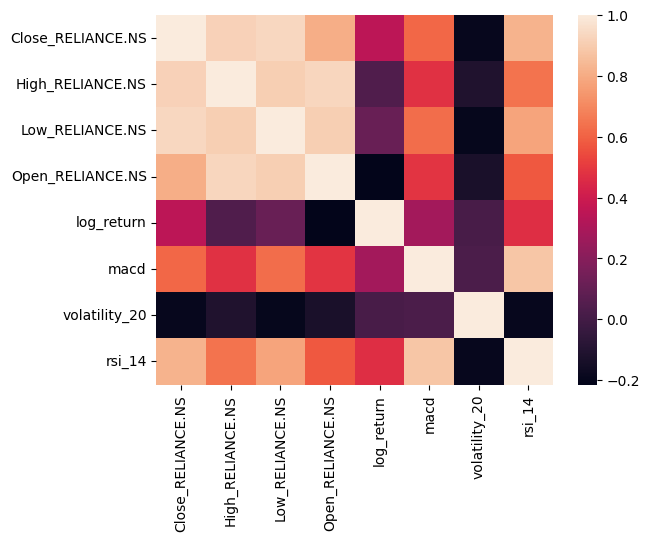

In [687]:
import seaborn as sns
numeric_df = df.select_dtypes(include=["float64"])
correlation = numeric_df.corr()

correlation = numeric_df.corr()
sns.heatmap(correlation)

From the above I found that Close, ma_5 and ma_20 are nearly same therefore can drop them as they may make more noise 


In [688]:
df_final = df

In [689]:
df_final["Date"] = pd.to_datetime(df_final["Date_"]).dt.date

# Merge sentiment
df_final = df_final.merge(
    sent_daily,
    on="Date",
    how="left"
)

# Check
df_final[["Date", "sentiment_num"]].tail(20)
df_final['sentiment_num'] = df_final["sentiment_num"].fillna(0)

In [691]:
df_final = df_final.replace([np.inf, -np.inf], np.nan)
df_final = df_final.dropna(subset=features)

In [692]:
features = [
    "log_return",          
    "Open_RELIANCE.NS",
    "High_RELIANCE.NS",
    "Low_RELIANCE.NS",
    "Close_RELIANCE.NS",
    "Volume_RELIANCE.NS",
    'sentiment_num',
    "rsi_14",
    "macd",
    "volatility_20"
]

target = "log_return"

# print(data["rsi_14"].head(20))
# print(data["rsi_14"].isna().sum())

df_final[features].describe()
# df_final['returns_'].head()

,log_return,Open_RELIANCE.NS,High_RELIANCE.NS,Low_RELIANCE.NS,Close_RELIANCE.NS,Volume_RELIANCE.NS,sentiment_num,rsi_14,macd,volatility_20
count,395.000000,395.000000,395.000000,395.000000,395.000000,3.950000e+02,395.000000,395.000000,395.000000,395.000000
mean,-0.002517,1094.332998,1103.509664,1079.796853,1090.273716,1.324426e+07,0.048101,44.455439,-0.865106,0.017756
std,0.015651,25.739227,25.264679,24.778725,24.098640,5.355448e+06,0.579002,11.095122,9.099489,0.004254
min,-0.045304,1051.691978,1054.649598,1022.457488,1036.221680,4.017223e+06,-1.000000,20.463674,-23.128584,0.011539
25%,-0.013006,1078.378518,1086.204633,1063.613340,1075.011353,9.755485e+06,0.000000,37.588610,-5.853573,0.014818
50%,-0.001028,1087.933741,1094.941000,1072.941121,1082.996826,1.206085e+07,0.000000,46.550635,1.547298,0.015877
75%,0.007605,1110.081508,1125.745314,1093.848913,1100.196411,1.542531e+07,0.000000,51.014636,5.881693,0.023386
max,0.058456,1162.441988,1168.152210,1154.365540,1161.304443,4.240194e+07,1.000000,77.030667,14.554960,0.024087


LSTM Architecture

In [693]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout=0.2):
        super(SentimentLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # Fully Connected Output Layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state h0 and cell state c0
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        # out shape: (batch_size, seq_length, hidden_dim)
        out, _ = self.lstm(x, (h0, c0))

        # Take output of the last time step
        out = out[:, -1, :]

        # Final prediction
        prediction = self.fc(out)

        return prediction

In [694]:
def create_sequences(X, y, seq_len=30):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 5

X = df_final[features].values
y = df_final[target].values

X_seq, y_seq = create_sequences(X, y, SEQ_LEN)

In [695]:
print("X shape:", X.shape)
print("X_seq shape:", X_seq.shape)
print("X_train shape:", X_train.shape)


X shape: (395, 10)
X_seq shape: (390, 5, 10)
X_train shape: (312, 5, 10)


In [696]:
split = int(0.8 * len(X_seq))

X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]


In [697]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


X_train shape: (312, 5, 10)
X_val shape: (78, 5, 10)


Scaling the data by converting the 3D x to 2D and then back to 3D

In [698]:
# Scale X
n_samples, timesteps, n_features = X_train.shape

X_train_2d = X_train.reshape(-1, n_features)
X_val_2d   = X_val.reshape(-1, n_features)

scaler_X = StandardScaler()
X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)
X_val_scaled_2d   = scaler_X.transform(X_val_2d)

X_train_s = X_train_scaled_2d.reshape(n_samples, timesteps, n_features)
X_val_s   = X_val_scaled_2d.reshape(X_val.shape[0], timesteps, n_features)

# Scale y
scaler_y = StandardScaler()
y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s   = scaler_y.transform(y_val.reshape(-1,1))



Using the self made model

In [699]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


input_dim = 10     
hidden_dim = 32               
num_layers = 1                

model = SentimentLSTM(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using device: cpu


In [700]:
X_train_t = torch.tensor(X_train_s, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_s, dtype=torch.float32).to(device)

X_val_t = torch.tensor(X_val_s, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val_s, dtype=torch.float32).to(device)


y_train_t = y_train_t.unsqueeze(1)
y_val_t = y_val_t.unsqueeze(1)

print("X_train shape:", X_train_t.shape)  
print("y_train shape:", y_train_t.shape) 

X_train shape: torch.Size([312, 5, 10])
y_train shape: torch.Size([312, 1, 1])


In [701]:
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    preds = model(X_train_t)          # forward pass
    loss = criterion(preds, y_train_t)

    loss.backward()
    optimizer.step()

    # ---- validation ----
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = criterion(val_preds, y_val_t)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {loss.item():.6f} | "
        f"Val Loss: {val_loss.item():.6f}"
    )

Epoch 01 | Train Loss: 1.006244 | Val Loss: 1.320370
Epoch 02 | Train Loss: 1.004728 | Val Loss: 1.321235
Epoch 03 | Train Loss: 1.003481 | Val Loss: 1.322270
Epoch 04 | Train Loss: 1.002493 | Val Loss: 1.323456
Epoch 05 | Train Loss: 1.001749 | Val Loss: 1.324759
Epoch 06 | Train Loss: 1.001225 | Val Loss: 1.326050
Epoch 07 | Train Loss: 1.000889 | Val Loss: 1.327111
Epoch 08 | Train Loss: 1.000702 | Val Loss: 1.327703
Epoch 09 | Train Loss: 1.000621 | Val Loss: 1.327681
Epoch 10 | Train Loss: 1.000602 | Val Loss: 1.327030
Epoch 11 | Train Loss: 1.000607 | Val Loss: 1.325854
Epoch 12 | Train Loss: 1.000611 | Val Loss: 1.324328
Epoch 13 | Train Loss: 1.000598 | Val Loss: 1.322647
Epoch 14 | Train Loss: 1.000566 | Val Loss: 1.320994
Epoch 15 | Train Loss: 1.000517 | Val Loss: 1.319528
Epoch 16 | Train Loss: 1.000459 | Val Loss: 1.318381
Epoch 17 | Train Loss: 1.000398 | Val Loss: 1.317656
Epoch 18 | Train Loss: 1.000342 | Val Loss: 1.317423
Epoch 19 | Train Loss: 1.000296 | Val Loss: 1.

In [702]:
model.eval()
with torch.no_grad():
    preds = model(X_val_t).cpu().numpy().flatten()


actual = y_val

In [703]:
def pred_future_combined(
    model,
    df,
    features,
    target,
    window_size=30,
    n_future=30,
    device="cpu"
):

    # roll_features = base_features + [target]
    model.eval()

    last_window = df[features].iloc[-window_size:].values
    future_preds = []
    current_window = last_window.copy()

    target_idx = features.index(target)

    for step in range(n_future):

        X_input = current_window.reshape(1, window_size, len(features))
        X_tensor = torch.tensor(X_input, dtype=torch.float32).to(device)

        with torch.no_grad():
            pred = model(X_tensor)

        pred_value = float(pred.cpu().numpy().flatten()[0])
        future_preds.append(pred_value)

        new_row = current_window[-1].copy()
        new_row[target_idx] = pred_value
        current_window = np.vstack([current_window[1:], new_row])

    return future_preds


In [704]:
future_prices = pred_future_combined(
    model=model,
    df=df_final,
    features=features,
    target="log_return",
    window_size=30,
    n_future=30
)

In [705]:
import numpy as np

actual_arr = np.array(actual, dtype=float)
preds_arr = np.array(preds, dtype=float)
future_arr = np.array(future_prices, dtype=float)


In [706]:

# Inverse transform (back to real price scale)
actual_real = scaler_y.inverse_transform(actual_arr.reshape(-1, 1)).ravel()
preds_real  = scaler_y.inverse_transform(preds_arr.reshape(-1, 1)).ravel()
future_real = scaler_y.inverse_transform(future_arr.reshape(-1, 1)).ravel()



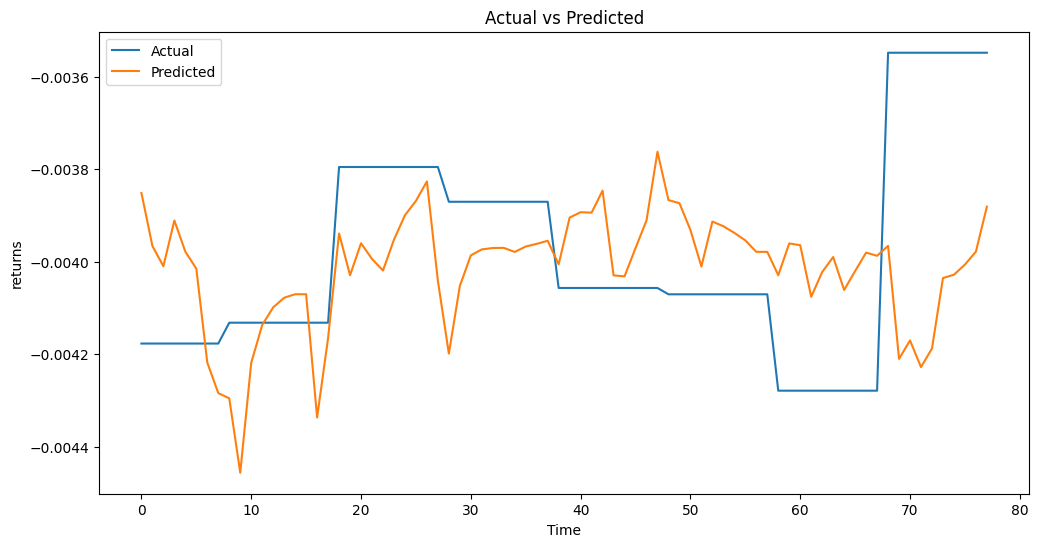

In [707]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,6))

plt.plot(actual_real, label="Actual")
plt.plot(preds_real, label="Predicted")



plt.xlabel("Time")
plt.ylabel("returns")
plt.title("Actual vs Predicted")
plt.legend()
plt.show()


Prediction Using the Model imported from KERAS

In [708]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError


In [709]:
model = Sequential([
    LSTM(64, input_shape=(timesteps, n_features), return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss=MeanSquaredError(),
    metrics=[MeanAbsoluteError()]
)

In [710]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0324 - mean_absolute_error: 0.8306 - val_loss: 1.2914 - val_mean_absolute_error: 0.8643
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9345 - mean_absolute_error: 0.7808 - val_loss: 1.1853 - val_mean_absolute_error: 0.8145
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8288 - mean_absolute_error: 0.7376 - val_loss: 1.0860 - val_mean_absolute_error: 0.7714
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7351 - mean_absolute_error: 0.6894 - val_loss: 1.0030 - val_mean_absolute_error: 0.7404
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6918 - mean_absolute_error: 0.6683 - val_loss: 0.9315 - val_mean_absolute_error: 0.7212
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6137 - mean_absolute_error: 0.6207 - val_loss: 0.8752 - val_mean_absolute_error: 0.7069
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5834 - mean_absolute_error: 0.6033 - val_loss: 0.82

In [711]:
preds_scaled = model.predict(X_val_s)

preds_real = scaler_y.inverse_transform(preds_scaled).ravel()
actual_real = scaler_y.inverse_transform(y_val_s).ravel()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


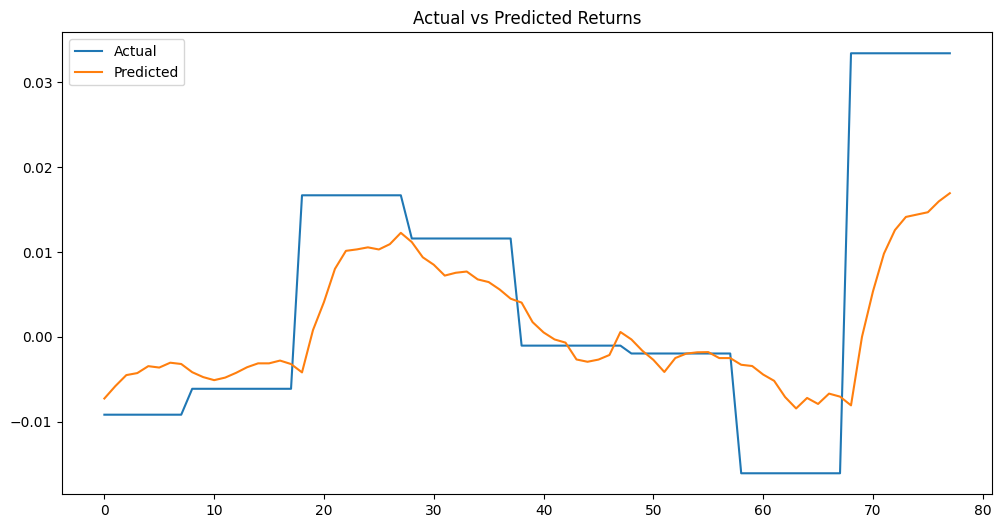

In [712]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(actual_real, label="Actual")
plt.plot(preds_real, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Returns")
plt.show()
